In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# read data 
calendar_df = pd.read_csv("/Users/khou/Desktop/DS/seattle/calendar.csv")
listings_df = pd.read_csv("/Users/khou/Desktop/DS/seattle/listings.csv")
reviews_df = pd.read_csv("/Users/khou/Desktop/DS/seattle/reviews.csv")

In [3]:
# data overview for calendar_df

#clean up columns type for calendar_df
calendar_df['date']= pd.to_datetime(calendar_df['date'])
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
# check column types
print(calendar_df.dtypes)
# check the time span of the listings
print(min(calendar_df['date']), max(calendar_df['date']))
# check the number of listings: 3818
calendar_df.listing_id.nunique()
# check for missing values: only price column has missing values, which is expected
calendar_df.isnull().sum()

listing_id             int64
date          datetime64[ns]
available             object
price                float64
dtype: object
2016-01-04 00:00:00 2017-01-02 00:00:00


listing_id         0
date               0
available          0
price         459028
dtype: int64

In [4]:
print(min(calendar_df['date']), max(calendar_df['date']))

2016-01-04 00:00:00 2017-01-02 00:00:00


In [5]:
# data overview for listings_df

# clean up column types for listings_df
listings_df['last_scraped'] = pd.to_datetime(listings_df['last_scraped'])
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.rstrip('%').astype('float') / 100
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex = True).astype(float)
listings_df['weekly_price'] = listings_df['weekly_price'].replace('[\$,]', '', regex = True).astype(float)
listings_df['monthly_price'] = listings_df['monthly_price'].replace('[\$,]', '', regex = True).astype(float)
listings_df['security_deposit'] = listings_df['security_deposit'].replace('[\$,]', '', regex = True).astype(float)
listings_df['cleaning_fee'] = listings_df['cleaning_fee'].replace('[\$,]', '', regex = True).astype(float)
# check that the column types are as expected
for col in listings_df.columns:
    print(col, ': ' , listings_df[col].dtypes)
    
# check for missing values
for col in listings_df.columns[listings_df.isnull().mean() != 0]:
    print(col, ': ', listings_df[col].isnull().sum().round(2)) # consider deleting square_feet

id :  int64
listing_url :  object
scrape_id :  int64
last_scraped :  datetime64[ns]
name :  object
summary :  object
space :  object
description :  object
experiences_offered :  object
neighborhood_overview :  object
notes :  object
transit :  object
thumbnail_url :  object
medium_url :  object
picture_url :  object
xl_picture_url :  object
host_id :  int64
host_url :  object
host_name :  object
host_since :  datetime64[ns]
host_location :  object
host_about :  object
host_response_time :  object
host_response_rate :  float64
host_acceptance_rate :  float64
host_is_superhost :  object
host_thumbnail_url :  object
host_picture_url :  object
host_neighbourhood :  object
host_listings_count :  float64
host_total_listings_count :  float64
host_verifications :  object
host_has_profile_pic :  object
host_identity_verified :  object
street :  object
neighbourhood :  object
neighbourhood_cleansed :  object
neighbourhood_group_cleansed :  object
city :  object
state :  object
zipcode :  object


In [6]:
# data overview for reviews_df

# clean up column types for listings_df
print(reviews_df.shape)
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
print(min(reviews_df['date']), max(reviews_df['date']))
print(reviews_df.dtypes)
reviews_df.head()

(84849, 6)
2009-06-07 00:00:00 2016-01-03 00:00:00
listing_id                int64
id                        int64
date             datetime64[ns]
reviewer_id               int64
reviewer_name            object
comments                 object
dtype: object


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [7]:
print(reviews_df['comments'].isnull().mean()) ## consider deleting the NA value since its a very small portion

0.00021214156914047309


Text(0, 0.5, 'Number of Listings')

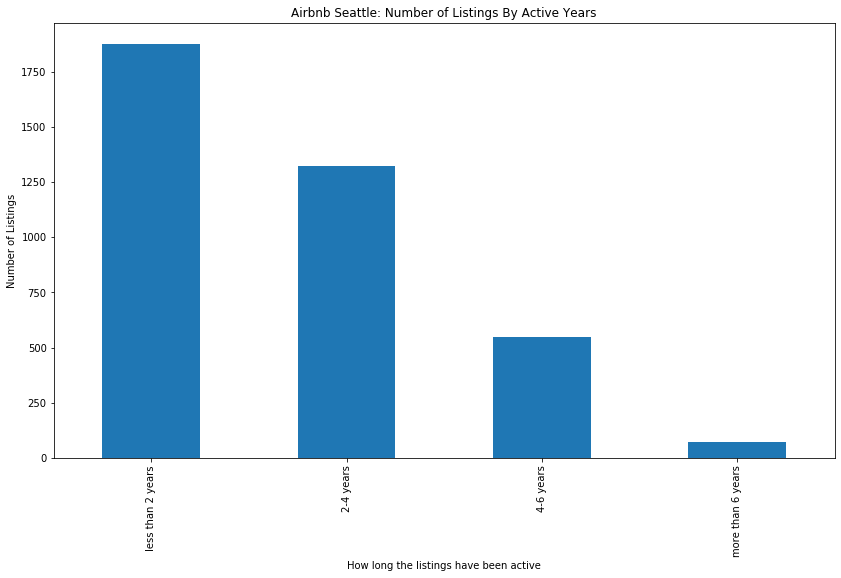

In [8]:
# question 1: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
# supply side(listings): check "host_since"
listings_df['listing_month'] = (listings_df['last_scraped'] - listings_df['host_since'])/ np.timedelta64(1, 'M')
listings_df['listing_age'] = np.where(listings_df['listing_month'] < 24, 
                                      'less than 2 years', 
                                      np.where((listings_df['listing_month'] >= 24) & 
                                               (listings_df['listing_month'] < 48),
                                              '2-4 years',
                                              np.where((listings_df['listing_month'] >= 48) & 
                                                       (listings_df['listing_month'] < 72),
                                                       '4-6 years', 'more than 6 years')))
ax = listings_df['listing_age'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Airbnb Seattle: Number of Listings By Active Years")
ax.set_xlabel("How long the listings have been active")
ax.set_ylabel("Number of Listings")



Text(0, 0.5, 'Number of Reviews')

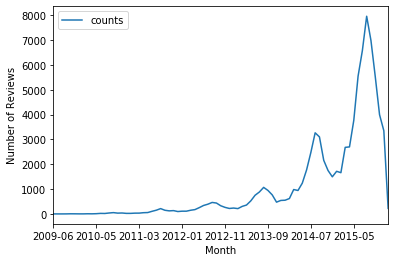

In [9]:
# question 1: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

# demand side(reviews): check count of reviews over time
reviews_df['year_month'] = reviews_df['date'].dt.strftime('%Y-%m')
rvw_cnt_ts = reviews_df.groupby(['year_month']).size().reset_index(name = 'counts').set_index('year_month').plot()
rvw_cnt_ts.set_xlabel("Month")
rvw_cnt_ts.set_ylabel("Number of Reviews")


Text(0, 0.5, 'Number of Available Listings')

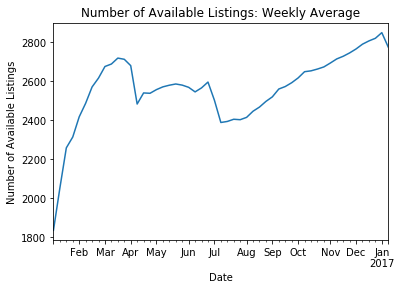

In [10]:
# question 2: when is the busiest season to rent for maximum revenue and when is the off-peak season for maintenance?

calendar_count_df = calendar_df.loc[calendar_df['available'] == 't'].groupby('date').listing_id.nunique().reset_index()
calendar_count_df.columns = ['date', 'day_count']
calendar_count_df.set_index('date', inplace=True)


weekly_resampled = calendar_count_df.day_count.resample('W').mean()
weekly_resampled.columns = ['weekly_avg']
weekly_plot = weekly_resampled.plot(title="Number of Available Listings: Weekly Average")
weekly_plot.set_xlabel("Date")
weekly_plot.set_ylabel("Number of Available Listings")

Text(0.5, 0, 'Month')

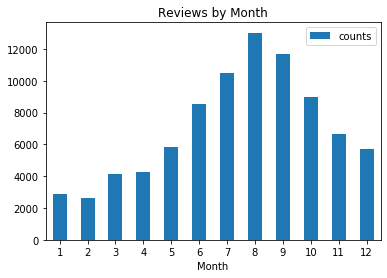

In [12]:
reviews_df['month']= reviews_df['date'].dt.month
rvw_cnt = reviews_df.groupby(['month']).size().reset_index(name = 'counts')
rvw_cnt.plot.bar(x = 'month', y='counts', rot=0,title="Reviews by Month").set_xlabel("Month")


In [14]:
# question 3: what factors are related to price?
# we build a model to predict the price for each listing### deal with missing values and categorical variables
# Drop rows with missing price values
listings_df_orig = listings_df
listings_df = listings_df.dropna(subset=['price'], axis=0)
y = listings_df['price']
listings_df = listings_df[['space',
                           'host_acceptance_rate', 
                           'host_listings_count',
                               'accommodates', 
                               'bathrooms', 
                               'bedrooms', 
                               'beds', 
                               'guests_included', 
                               'review_scores_rating',
                               'review_scores_accuracy',
                               'review_scores_cleanliness',
                               'review_scores_checkin',
                               'review_scores_communication',
                               'review_scores_location',
                               'review_scores_value',
                               'reviews_per_month',
                               'host_response_time',
                               'host_is_superhost',
                               'host_identity_verified',
                               'neighbourhood_group_cleansed',
                               'property_type',
                               'room_type',
                               'bed_type',               
                               'cancellation_policy',
                               'require_guest_profile_picture',
                               'require_guest_phone_verification']]
# Fill numeric columns with the mean
num_vars = listings_df.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    listings_df[col].fillna((listings_df[col].mean()), inplace=True)
        
# Dummy the categorical variables
cat_vars = listings_df.select_dtypes(include=['object']).copy().columns
for var in cat_vars:
    # for each cat add dummy var, drop original column
    listings_df = pd.concat([listings_df.drop(var, axis=1), pd.get_dummies(listings_df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
X = listings_df



In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [17]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(15)

,est_int,coefs,abs_coefs
222,space_A nice homey-feeling place on top of Que...,-1.329616e+17,1.329616e+17
177,space_A Seattle Times featured Home- New unobs...,-1.190452e+17,1.190452e+17
801,space_History: This secret hideout is a blast ...,-1.152071e+17,1.152071e+17
586,space_EXCELLENT LOCATION MEANS FREEDOM IN SEAT...,1.124516e+17,1.124516e+17
1211,"space_Newly decorated guest room, with garden ...",1.112494e+17,1.112494e+17
287,"space_Amazing views over the ocean, islands an...",-9.697754e+16,9.697754e+16
296,space_Apartment is right on Broadway - a very ...,-9.364150e+16,9.364150e+16
239,space_A ten minute walk to downtown Ballard.,9.354180e+16,9.354180e+16
1196,space_Need more space? This is the Place! Thi...,8.815161e+16,8.815161e+16
1210,"space_Newly built and beautifully designed, th...",8.664164e+16,8.664164e+16
